In [1]:
import json
import pandas as pd
import numpy as np
import os
import re

In [2]:
def get_filenames():
    current_working_dir = os.getcwd()
    folder = "cuckoo_reports"
    folder_path = os.path.join(current_working_dir,folder)

    file_list = []

    try:
        filenames = os.listdir(folder_path)

        for filename in filenames:
            if filename.endswith(".json"):
                file_list.append(filename)
    except FileNotFoundError:
        print(f"The folder '{folder_path}' was not found.")

    return(file_list)

def create_dataframe(api_dict,file):
    jsonFile = open(f"cuckoo_reports/{file}",'r')
    values = json.load(jsonFile)
    jsonFile.close()

    for process_id,api_data in values['behavior']['apistats'].items():
        for key, value in api_data.items():
            if(not api_dict):
                # print(api_dataframe)
                api_dict = api_data
                # print("after null detection i m breaking",len(api_dataframe))
                break
            tmp = list(api_dict)
            length = len(tmp)
            count = 0
            for item in tmp:
                count +=1
                if item==key:
                    api_dict[item] += api_data[key]
                    break
                if(count>=length):
                    api_dict[key]=api_data[key]
    if(re.search(r'BENIGN',file)):
        api_dict['Malware']=0
    else:
        api_dict['Malware']=1
    return api_dict

file_list = get_filenames()
api_list = []
for file in file_list:
    api_dict = {}
    api_dict=create_dataframe(api_dict,file)
    # print(api_dataframe)
    api_list.append(api_dict)
    # print(len(api_dict))

df=pd.DataFrame(api_list)

#PRINTING IF WE HAVE CORRECT DATA FRAME SHAPE AND #OF MALWARES
print(np.shape(df))
print(df['Malware'].value_counts())

(105, 217)
Malware
0    68
1    37
Name: count, dtype: int64


In [3]:

print(df.isna().sum())

#DATA CLEANING PROCESS BY FILLING NAN VALUES WITH 0
#filling nan values with 0
df.fillna(0, inplace=True)
print(df.isna().sum())


LdrUnloadDll                     7
NtOpenKey                        3
SetUnhandledExceptionFilter      9
NtTerminateProcess               6
NtClose                          1
                              ... 
setsockopt                     104
Module32FirstW                 104
Module32NextW                  104
RegQueryInfoKeyA               104
NtDeleteKey                    104
Length: 217, dtype: int64
LdrUnloadDll                   0
NtOpenKey                      0
SetUnhandledExceptionFilter    0
NtTerminateProcess             0
NtClose                        0
                              ..
setsockopt                     0
Module32FirstW                 0
Module32NextW                  0
RegQueryInfoKeyA               0
NtDeleteKey                    0
Length: 217, dtype: int64


In [4]:
#NORMALIZING DATA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Data labeling
X = df[df.columns.difference(['Malware'])]
y = df['Malware']

print(np.shape(X),"\n",np.shape(y))

#Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = y

print(X_scaled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state = 42)
print("X_train shape :",np.shape(X_train),"\n","y_train shape :",np.shape(y_train),"\n",
      "X_test shape :",np.shape(X_test),"\n","y_test shape :",np.shape(y_test),"\n")


(105, 216) 
 (105,)
[[-0.4612911  -0.13791932 -0.15812303 ... -0.10743089 -0.09805807
  -0.26352314]
 [ 0.68173109 -0.13791932 -0.15812303 ... -0.10743089 -0.09805807
  -0.26352314]
 [ 0.68173109 -0.13791932 -0.15812303 ... -0.10743089 -0.09805807
  -0.26352314]
 ...
 [-0.4612911  -0.13791932 -0.15812303 ... -0.10743089 -0.09805807
  -0.26352314]
 [-0.4612911  -0.13791932 -0.15812303 ... -0.10743089 -0.09805807
  -0.26352314]
 [-0.4612911  -0.13791932 -0.15812303 ... -0.10743089 -0.09805807
  -0.26352314]]
X_train shape : (84, 216) 
 y_train shape : (84,) 
 X_test shape : (21, 216) 
 y_test shape : (21,) 



In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn as sklearn
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


#Result Printing Function

def print_result(y_test, y_pred, model_name):

    # Calculate accuracy, precision, recall, F1 score, and confusion matrix
    accuracy = round(accuracy_score(y_test, y_pred),2)
    precision = round(precision_score(y_test, y_pred),2)
    recall = round(recall_score(y_test, y_pred),2)
    f1 = round(f1_score(y_test, y_pred),2)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    TN, FP, FN, TP = conf_matrix.ravel()
    tpr = round(TP / (TP + FN),2)
    fpr = round(FP / (FP + TN),2)

    # Print the evaluation metrics
    print("\nEvaluation for Model :",model_name)
    print("----------------------------------")
    print("Test accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("True Positive Rate (TPR):", tpr)
    print("False Positive Rate (FPR):", fpr)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()



Evaluation for Model : Random Forest
----------------------------------
Test accuracy: 0.9
Precision: 1.0
Recall: 0.71
F1 Score: 0.83
True Positive Rate (TPR): 0.71
False Positive Rate (FPR): 0.0


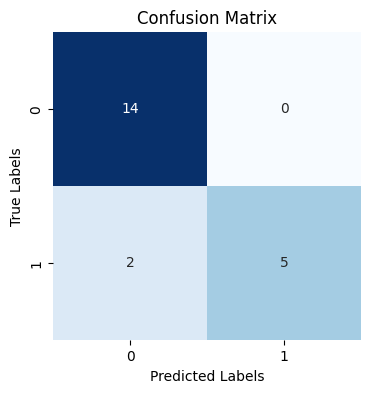


Evaluation for Model : KNN Model
----------------------------------
Test accuracy: 0.81
Precision: 0.43
Recall: 1.0
F1 Score: 0.6
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.22


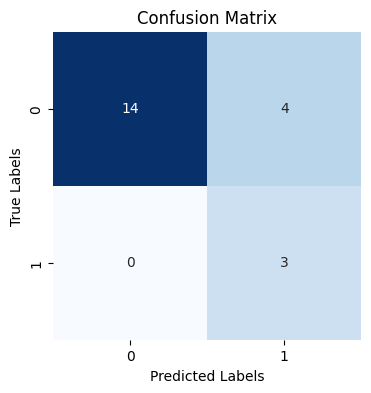


Evaluation for Model : Naive Bayes Model
----------------------------------
Test accuracy: 0.95
Precision: 1.0
Recall: 0.88
F1 Score: 0.93
True Positive Rate (TPR): 0.88
False Positive Rate (FPR): 0.0


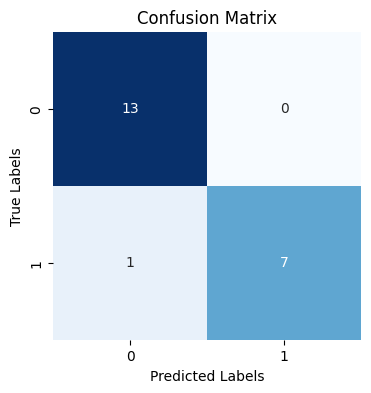

In [6]:
#--------------Model 1 : Random Forest-------------------------------#
RF = RandomForestClassifier(random_state=1)
RF.fit(X_train, y_train)


y_predRF = RF.predict(X_test)


print_result(y_test,y_predRF, model_name="Random Forest")


#--------------Model 2 : KNN Model-----------------------------------#


knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)


# Make predictions on the test set
y_predKNN = knn_model.predict(X_test)


print_result(y_predKNN, y_test, model_name="KNN Model")


#--------------Other Tested Model : NaiveBayes Mdoel------------------#
#After multiple hit and trial, with very less threshold, FPR decreases but the model is overfitted.


NaiveBayes = GaussianNB()
NaiveBayes.fit(X_train, y_train)


threshold = 0.5


# Make predictions on the test set using predict_proba
y_prob = NaiveBayes.predict_proba(X_test)
y_predNB = (y_prob[:, 1] > threshold).astype(int) # Classify as 1 if the probability is above the threshold


print_result(y_predNB, y_test, model_name="Naive Bayes Model")


#-------------------------------------------------------#



In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import layers
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

#history = model.fit(X_train,y_train,validation_split=.33,epochs=50,batch_size=1)


#def create_model(neurons = 1, )


In [8]:
def create_model(neurons_1 = 20, dropout = .01, activation = 'relu',bias_initializer = 'zeros'):
    model = Sequential()
    #kernal_weight init try norm, moer
    model.add(Dense(neurons_1,input_dim=216,activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(neurons_1,activation=activation,bias_initializer=bias_initializer))
    #model.add(layers.SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model


In [9]:
predictor = KerasClassifier(build_fn=create_model, verbose=1,epochs=200)
param_grid = {'model__neurons_1': [5,40,60,120],
              'model__dropout': [0,0.1,0.01],
              'model__activation': ['relu','sigmoid'],
              'model__bias_initializer': ['zeroes','RandomUniform','TruncatedNormal']}

grid = GridSearchCV(estimator=predictor, param_grid=param_grid, n_jobs=-1, cv=None, verbose = 0)
print(predictor.get_params())
grid.fit(X_train,y_train)

{'model': None, 'build_fn': <function create_model at 0x000002647FF07E20>, 'warm_start': False, 'random_state': None, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': None, 'validation_batch_size': None, 'verbose': 1, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 200, 'class_weight': None}
Epoch 1/200


C:\Users\Hunter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hunter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hunter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\loca

3/3 [==============================] - 0s 4ms/step - loss: 0.5785 - accuracy: 0.7619
Epoch 2/200
3/3 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.8929
Epoch 3/200
3/3 [==============================] - 0s 2ms/step - loss: 0.3115 - accuracy: 0.8690
Epoch 4/200
3/3 [==============================] - 0s 1ms/step - loss: 0.2742 - accuracy: 0.8929
Epoch 5/200
3/3 [==============================] - 0s 2ms/step - loss: 0.2336 - accuracy: 0.9048
Epoch 6/200
3/3 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9643
Epoch 7/200
3/3 [==============================] - 0s 1ms/step - loss: 0.1856 - accuracy: 0.9524
Epoch 8/200
3/3 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9524
Epoch 9/200
3/3 [==============================] - 0s 1ms/step - loss: 0.1679 - accuracy: 0.9643
Epoch 10/200
3/3 [==============================] - 0s 1ms/step - loss: 0.1526 - accuracy: 0.9643
Epoch 11/200
3/3 [=======================

GridSearchCV(estimator=KerasClassifier(build_fn=<function create_model at 0x000002647FF07E20>, epochs=200),
             n_jobs=-1,
             param_grid={'model__activation': ['relu', 'sigmoid'],
                         'model__bias_initializer': ['zeroes', 'RandomUniform',
                                                     'TruncatedNormal'],
                         'model__dropout': [0, 0.1, 0.01],
                         'model__neurons_1': [5, 40, 60, 120]})

1/1 [==============================] - 0s 61ms/step
{'model__activation': 'relu', 'model__bias_initializer': 'RandomUniform', 'model__dropout': 0.1, 'model__neurons_1': 60}

Evaluation for Model : Feed Forward Neural Net
----------------------------------
Test accuracy: 0.86
Precision: 0.57
Recall: 1.0
F1 Score: 0.73
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.18


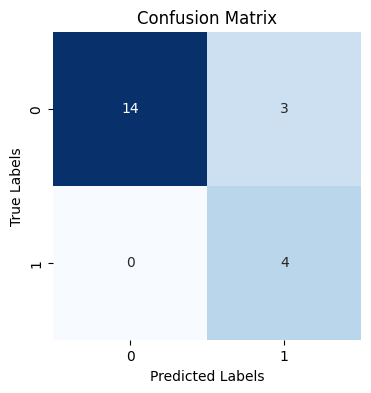

In [10]:
y_predNN = grid.predict(X_test)
y_predNN = np.where(y_predNN > .5,1,0)
print(grid.best_params_)
print_result(y_predNN, y_test, model_name="Feed Forward Neural Net")

In [11]:
NNModel = create_model(neurons_1= grid.best_params_['model__neurons_1'],dropout=grid.best_params_['model__dropout'],activation=grid.best_params_['model__activation'],bias_initializer=grid.best_params_['model__bias_initializer'])
NNModel.fit(X_train,y_train,validation_split=.33,epochs=200,verbose=0)

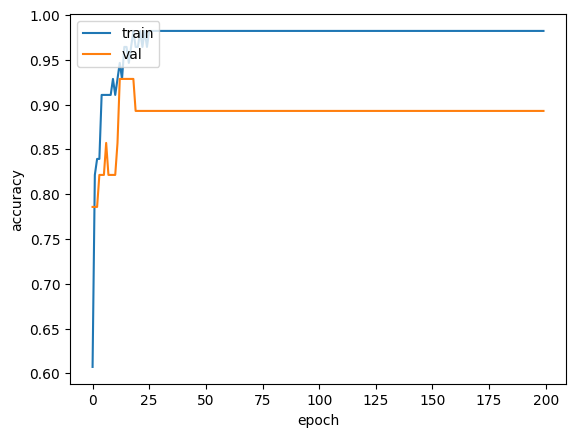

In [12]:
plt.plot(NNModel.history.history['accuracy'])
plt.plot(NNModel.history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

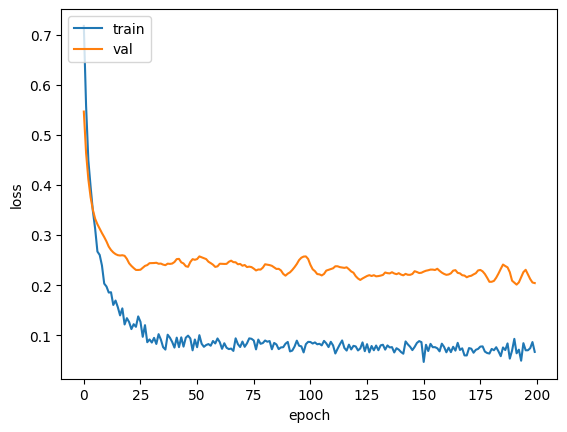

In [13]:
plt.plot(NNModel.history.history['loss'])
plt.plot(NNModel.history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()